In [716]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms.functional as fn
from torchvision import datasets, transforms
from datetime import datetime
from typing import Sequence
from torch.utils.data import random_split
from random import randint
import matplotlib.pyplot as plt 
import cv2 as cv
import plotly.graph_objects as go

torch.manual_seed(123)


In [717]:
data_train = torch.load('localization_train.pt')
data_val = torch.load('localization_val.pt')
data_test = torch.load('localization_test.pt')

In [718]:
print(len(data_train))
print(len(data_val))
print(len(data_test))

59400
6600
11000


In [719]:
i = 0
i_elt = data_train[i]
# Type of the ith element of the training dataset: 
print("Type of the ith element in the dataset  :  ", type(i_elt))
print("Tuple length of this element            :  ", len(i_elt))
print("Type of the 1st element of the tuple    :  ", type(i_elt[0]))
print("Type of the 2nd element of the tuple    :  ", type(i_elt[1]))

# The dataset is then made like this "i_img, i_label =  cifar10_train[i]""
print(i_elt[0].size())

Type of the ith element in the dataset  :   <class 'tuple'>
Tuple length of this element            :   2
Type of the 1st element of the tuple    :   <class 'torch.Tensor'>
Type of the 2nd element of the tuple    :   <class 'torch.Tensor'>
torch.Size([1, 48, 60])


In [720]:
labels = [int(data[1][5].item()) for data in data_train]

classes = set(labels)

num = [0]*len(classes)

for val in classes:
    num[val] = labels.count(val)


fig = go.Figure()
fig.add_trace(go.Bar(x=list(classes),
                y= num
                ))

fig.show()


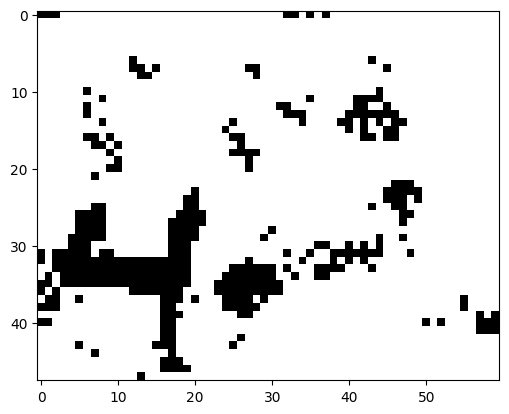

In [721]:
index = randint(0, len(data_train))
el = data_train[index]
t = 0.7
binary_mask = el[0].squeeze(0) < t

fig, ax = plt.subplots()
plt.imshow(binary_mask, cmap="gray")


In [722]:

squeeze_threshold = lambda x : tuple(list(el)[0] < 0.7)

squeeze_threshold(data_train)
squeeze_threshold(data_val)
squeeze_threshold(data_test)

(tensor([[False, False, False,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True]]),)

In [723]:
device = torch.device('cpu')
print(f"Device {device}.")

def loss(y_pred, y_true):
    i_where_num = torch.where(y_true[:,0] == 1)
    l_a = nn.functional.binary_cross_entropy_with_logits(y_pred[:, 0], y_true[:, 0])        #”Is there an object in the image? ”.
    
    y_true_num, y_pred_num = y_true[i_where_num], y_pred[i_where_num]                       #Picking the tensors where there is a num in picture

    l_b = nn.functional.mse_loss(y_pred_num[:, 1:5], y_true_num[:, 1:5])                    #”Where is the object?”
    l_c = nn.functional.cross_entropy(y_pred_num[:, 5:], y_true_num[:, 5].long())           #”Which class is this? ”                                                 #

    total_loss = l_a + l_b + l_c
    return total_loss

def train(n_epochs, optimizer, model, loss_fn, train_loader):
    """
    Train our model and save weight values
    """
    n_batch = len(train_loader)
    losses_train = []
    model.train()
    optimizer.zero_grad(set_to_none=True)
    
    weight_values = []
    bias_values = []
    
    for epoch in range(1, n_epochs + 1):
        
        loss_train = 0.0
        for imgs, labels in train_loader:

            imgs = imgs.to(device=device, dtype=torch.float) 
            labels = labels.to(device=device)

            outputs = model(imgs)
            
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_train += loss.item()
            
        losses_train.append(loss_train / n_batch)
        
        # Here we store weight values at each step of the training process
        # with torch.no_grad():
        #     weight_values.append(model.conv1.weight.data.clone().detach())
        #     if model.conv1.bias is not None:
        #         bias_values.append(model.conv1.bias.data.clone().detach())

        print('{}  |  Epoch {}  |  Training loss {:.5f}'.format(
            datetime.now().time(), epoch, loss_train / n_batch))
    return losses_train


from matplotlib.patches import Rectangle
from collections import namedtuple

def give_img_with_boundingboxes(model, loader,  num_imgs): 

    with torch.no_grad():
        for imgs, labels in loader: 
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)

            outputs = model(imgs)

        for i in range(num_imgs):

            i = randint(i, len(outputs))

            if labels[i, 0] != 0: 
                tx, ty, tw, th = labels[i, 1:5]
                tx = (tx - tw*0.5)*imgs.shape[3]
                ty = (ty - th*0.5)*imgs.shape[2]
                tw = tw * imgs.shape[3]
                th = th * imgs.shape[2]

                fig, ax = plt.subplots()
                plt.imshow(imgs[i].squeeze(0))
                rect_true = Rectangle((tx,ty), tw, th,
                    edgecolor='red',
                    facecolor='none',
                    lw=4)
                ax.add_patch(rect_true)

                px, py, pw, ph = outputs[i, 1:5]
                px = (px - pw*0.5)*imgs.shape[3]
                py = (py - ph*0.5)*imgs.shape[2]
                pw = pw * imgs.shape[3]
                ph = ph * imgs.shape[2]

                plt.imshow(imgs[i].squeeze(0))
                rect_pred = Rectangle((px,py), pw, ph,
                    edgecolor='blue',
                    facecolor='none',
                    lw=4)
                ax.add_patch(rect_pred)
                
                plt.show()

                print(labels[i, 5])
                print(torch.argmax(outputs[i, 5:]))

     
                
Rect = namedtuple('Rectangle', 'xmin ymin xmax ymax')

def area(a, b):  
    dx = min(a.xmax, b.xmax) - max(a.xmin, b.xmin)
    dy = min(a.ymax, b.ymax) - max(a.ymin, b.ymin)
    if (dx>=0) and (dy>=0):
        return dx*dy
    else: 
        return 0 


def compute_accuracy(model, loader):
    correct = 0
    total = 0
    iou = 0 
    num_ob = 0 

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)

            _, predicted = torch.max(outputs[:, 5:], dim = 1)

            for i in range(len(labels)): 
                total += 1
                if torch.sigmoid(outputs[i, 0]) < 0.5 and labels[i, 0] == 0: 
                    correct += 1
                
                if torch.sigmoid(outputs[i, 0]) >= 0.5 and labels[i, 0] == 1:
                    num_ob += 1
                    pred = predicted[i]
                    true = labels[i, 5]

                    if pred == true:
                        correct += 1
                    
                    px, py, pw, ph = outputs[i, 1:5]
                    tx, ty, tw, th = labels[i, 1:5]

                    px_min, py_min, px_max, py_max = px - pw/2, py - ph/2, px + pw/2 , py + ph/2
                    tx_min, ty_min, tx_max, ty_max = tx - tw/2, ty - th/2, tx + tw/2 , ty + th/2

                    p_rect = Rect(px_min, py_min, px_max, py_max)
                    t_rect = Rect(tx_min, ty_min, tx_max, ty_max)

                    intersection = area(p_rect, t_rect)
                    union = pw*ph + tw*th - intersection
                    iou += intersection/union
                    

    acc =  ((correct / total) + (iou / num_ob)) / 2
    print("Accuracy: {:.2f}".format(acc))
    return acc




Device cpu.


In [724]:
class MyLeNet5(nn.Module):
    def __init__(self, num_classes):
        super().__init__() 
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)  
        self.norm1 = nn.BatchNorm2d(6)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.norm2 = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(2)
        
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(in_features=2080, out_features=120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, num_classes)


    def forward(self, x):
        
        out = self.conv1(x)
        out = self.norm1(out)
        out = torch.relu(self.pool1(out))
        
        out = self.conv2(out)
        out = self.norm2(out)
        out = torch.relu(self.pool2(out))
        
        out = self.flat(out)
        out = torch.relu(self.fc1(out))
        out = torch.relu(self.fc2(out))
        out = self.fc3(out)

        return out
    

    

In [725]:
n_epochs = 25
train_loader = torch.utils.data.DataLoader(data_train, batch_size=512, shuffle=False)
val_loader = torch.utils.data.DataLoader(data_val, batch_size=512, shuffle=False)

imgs = torch.stack([img for img, _ in data_train])
mean = imgs.mean()
std = imgs.std()

normalizer = transforms.Normalize(mean, std)

for img, target in train_loader:
    img = normalizer(img)

for img, target in val_loader: 
    img = normalizer(img)


best_model = ''
best_val_acc = 0


20:45:03.804717  |  Epoch 1  |  Training loss 2.88611
20:45:30.806190  |  Epoch 2  |  Training loss 2.65407
20:45:56.400805  |  Epoch 3  |  Training loss 2.60685
20:46:28.870807  |  Epoch 4  |  Training loss 2.59235
20:46:58.110554  |  Epoch 5  |  Training loss 2.58538
20:47:23.933986  |  Epoch 6  |  Training loss 2.58000
20:47:51.680770  |  Epoch 7  |  Training loss 2.57510
20:48:18.199041  |  Epoch 8  |  Training loss 2.57046
20:48:43.682053  |  Epoch 9  |  Training loss 2.56601
20:49:08.437393  |  Epoch 10  |  Training loss 2.56172
20:49:33.973488  |  Epoch 11  |  Training loss 2.55751
20:49:59.709214  |  Epoch 12  |  Training loss 2.55334
20:50:25.313859  |  Epoch 13  |  Training loss 2.54918
20:50:49.803144  |  Epoch 14  |  Training loss 2.54497
20:51:14.091542  |  Epoch 15  |  Training loss 2.54068
20:51:38.989961  |  Epoch 16  |  Training loss 2.53624
20:52:03.994536  |  Epoch 17  |  Training loss 2.53163
20:52:28.782022  |  Epoch 18  |  Training loss 2.52675
20:52:53.899566  | 

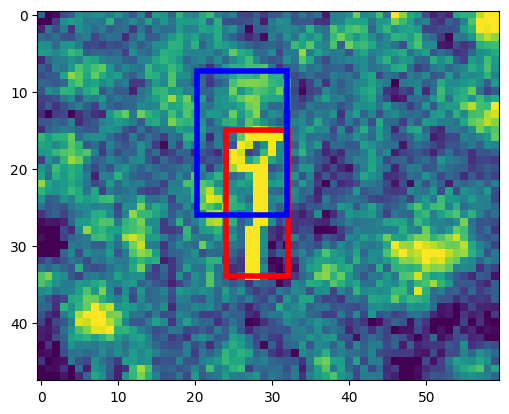

tensor(9.)
tensor(3)


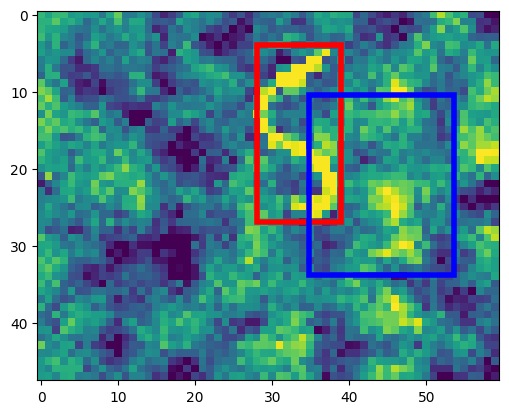

tensor(5.)
tensor(3)


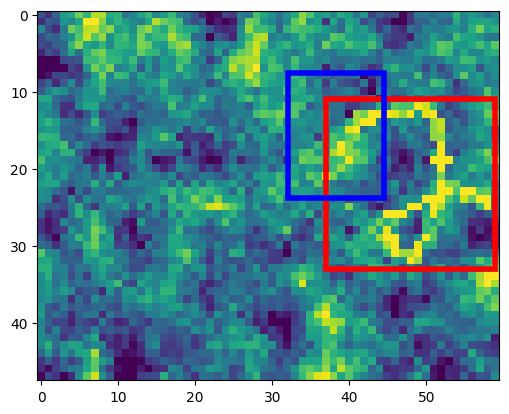

tensor(2.)
tensor(9)


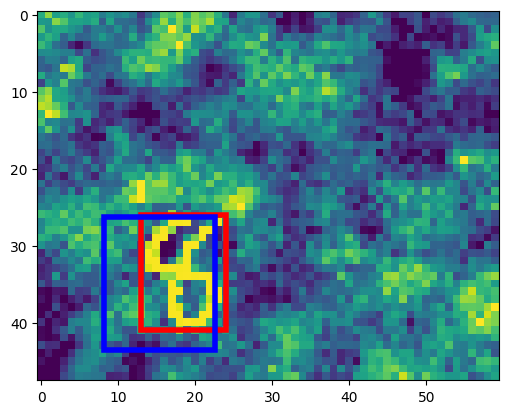

tensor(8.)
tensor(6)
Accuracy: 0.23


In [726]:
CNN_model1 = MyLeNet5(15)
optimizer = optim.SGD(CNN_model1.parameters(), lr=1e-3)

train(
    n_epochs = n_epochs, 
    optimizer = optimizer, 
    model = CNN_model1, 
    loss_fn = loss, 
    train_loader = train_loader)

give_img_with_boundingboxes(CNN_model1, val_loader, 5)

model1_acc = compute_accuracy(CNN_model1, val_loader)

if model1_acc > best_val_acc:
    best_model = CNN_model1
    best_model_name = 'CNN_model1'
    best_val_acc = model1_acc

20:55:58.308748  |  Epoch 1  |  Training loss 2.72497
20:56:23.944505  |  Epoch 2  |  Training loss 2.60795
20:56:48.970764  |  Epoch 3  |  Training loss 2.59644
20:57:14.116671  |  Epoch 4  |  Training loss 2.58617
20:57:39.824379  |  Epoch 5  |  Training loss 2.57652
20:58:05.024012  |  Epoch 6  |  Training loss 2.56743
20:58:30.253785  |  Epoch 7  |  Training loss 2.55876
20:58:55.476456  |  Epoch 8  |  Training loss 2.55030
20:59:21.107234  |  Epoch 9  |  Training loss 2.54196
20:59:46.522762  |  Epoch 10  |  Training loss 2.53368
21:00:13.245620  |  Epoch 11  |  Training loss 2.52541
21:00:38.767930  |  Epoch 12  |  Training loss 2.51714
21:01:08.264594  |  Epoch 13  |  Training loss 2.50888
21:01:37.108695  |  Epoch 14  |  Training loss 2.50071
21:02:07.052459  |  Epoch 15  |  Training loss 2.49268
21:02:32.920144  |  Epoch 16  |  Training loss 2.48481
21:02:58.742701  |  Epoch 17  |  Training loss 2.47712
21:03:24.397436  |  Epoch 18  |  Training loss 2.46962
21:03:50.780192  | 

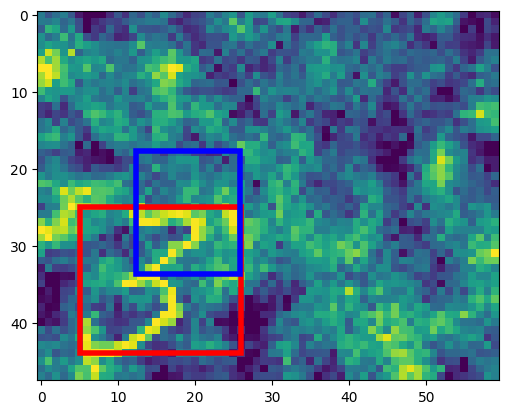

tensor(3.)
tensor(0)


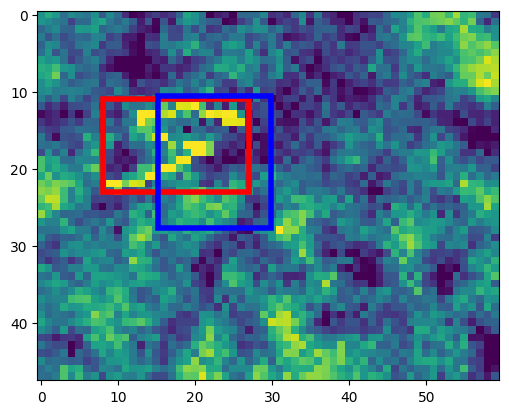

tensor(9.)
tensor(0)


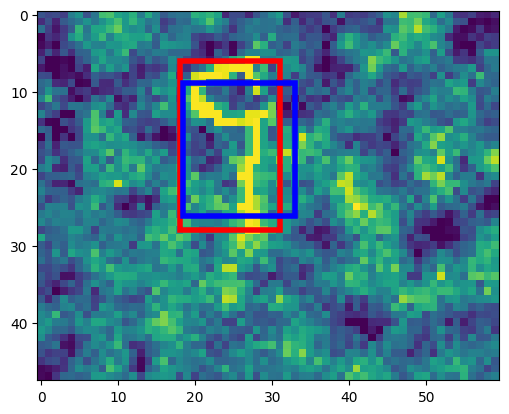

tensor(9.)
tensor(8)


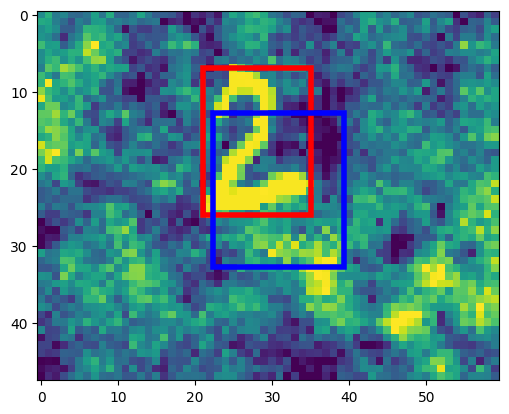

tensor(2.)
tensor(0)


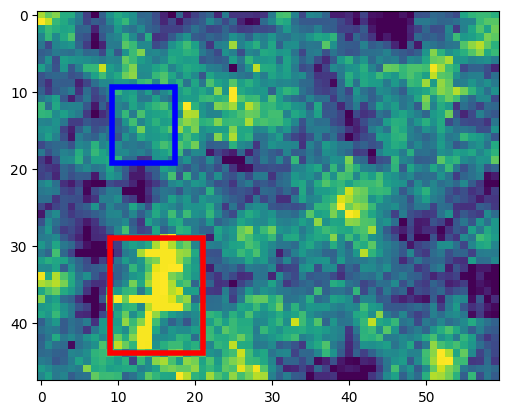

tensor(7.)
tensor(3)
Accuracy: 0.17


In [727]:
CNN_model2 = MyLeNet5(15)
optimizer = optim.SGD(CNN_model2.parameters(), lr=1e-3, weight_decay=0.1, momentum=0.7)

train(
    n_epochs = n_epochs, 
    optimizer = optimizer, 
    model = CNN_model2, 
    loss_fn = loss, 
    train_loader = train_loader)

give_img_with_boundingboxes(CNN_model2, val_loader, 5)

model2_acc = compute_accuracy(CNN_model2, val_loader)

if model2_acc > best_val_acc:
    best_model = CNN_model2
    best_model_name = 'CNN_model2'
    best_val_acc = model2_acc

21:06:57.625030  |  Epoch 1  |  Training loss 2.81302
21:07:23.400578  |  Epoch 2  |  Training loss 2.62993
21:07:49.346528  |  Epoch 3  |  Training loss 2.60798
21:08:14.879518  |  Epoch 4  |  Training loss 2.60054
21:08:41.138042  |  Epoch 5  |  Training loss 2.59703
21:09:06.955242  |  Epoch 6  |  Training loss 2.59503
21:09:32.814350  |  Epoch 7  |  Training loss 2.59373
21:09:59.005666  |  Epoch 8  |  Training loss 2.59294
21:10:24.513245  |  Epoch 9  |  Training loss 2.59253
21:10:51.158894  |  Epoch 10  |  Training loss 2.59240
21:11:17.717206  |  Epoch 11  |  Training loss 2.59252
21:11:43.554836  |  Epoch 12  |  Training loss 2.59288
21:12:09.542158  |  Epoch 13  |  Training loss 2.59346
21:12:35.757738  |  Epoch 14  |  Training loss 2.59421
21:13:01.232121  |  Epoch 15  |  Training loss 2.59510
21:13:27.605334  |  Epoch 16  |  Training loss 2.59612
21:13:53.719113  |  Epoch 17  |  Training loss 2.59725
21:14:19.623040  |  Epoch 18  |  Training loss 2.59849
21:14:45.899626  | 

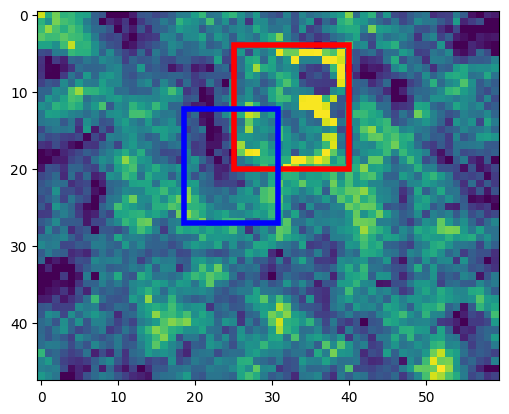

tensor(3.)
tensor(3)


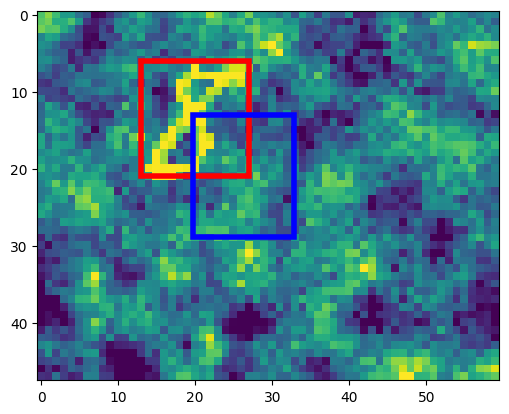

tensor(8.)
tensor(3)


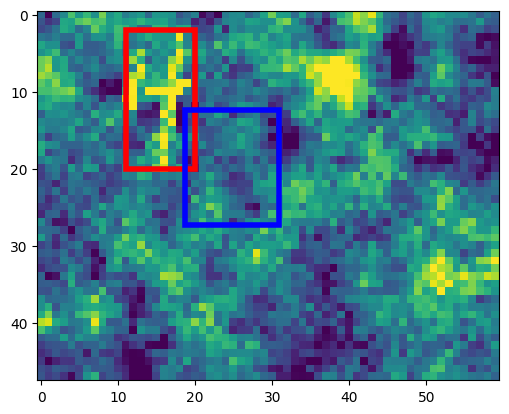

tensor(4.)
tensor(3)


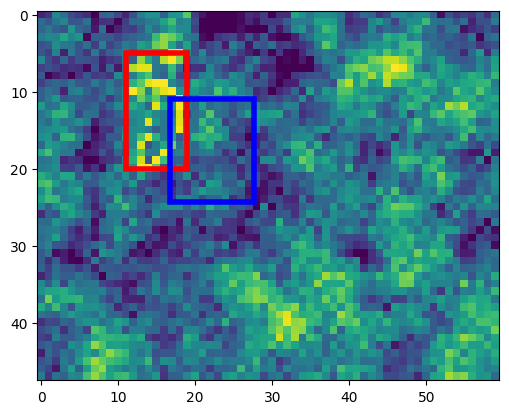

tensor(8.)
tensor(3)


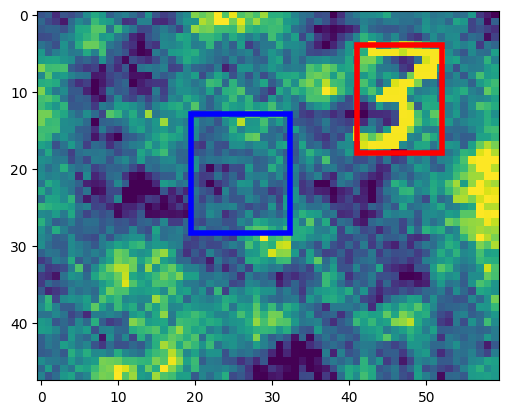

tensor(3.)
tensor(3)
Accuracy: 0.11


In [728]:
CNN_model3 = MyLeNet5(15)
optimizer = optim.SGD(CNN_model3.parameters(), lr=1e-3, weight_decay=0.5, momentum=0.2)

train(
    n_epochs = n_epochs, 
    optimizer = optimizer, 
    model = CNN_model3, 
    loss_fn = loss, 
    train_loader = train_loader)

give_img_with_boundingboxes(CNN_model3, val_loader, 5)

model3_acc = compute_accuracy(CNN_model3, val_loader)

if model3_acc > best_val_acc:
    best_model = CNN_model3
    best_model_name = 'CNN_model3'
    best_val_acc = model3_acc

21:17:53.608424  |  Epoch 1  |  Training loss 2.81122
21:18:19.331106  |  Epoch 2  |  Training loss 2.59876
21:18:44.612616  |  Epoch 3  |  Training loss 2.57784
21:19:10.134159  |  Epoch 4  |  Training loss 2.56753
21:19:35.970612  |  Epoch 5  |  Training loss 2.55927
21:20:01.776435  |  Epoch 6  |  Training loss 2.55213
21:20:27.808271  |  Epoch 7  |  Training loss 2.54558
21:20:53.216468  |  Epoch 8  |  Training loss 2.53922
21:21:18.666780  |  Epoch 9  |  Training loss 2.53269
21:21:44.534207  |  Epoch 10  |  Training loss 2.52605
21:22:10.203461  |  Epoch 11  |  Training loss 2.51938
21:22:36.143890  |  Epoch 12  |  Training loss 2.51257
21:23:01.791102  |  Epoch 13  |  Training loss 2.50549
21:23:27.871525  |  Epoch 14  |  Training loss 2.49823
21:23:53.563976  |  Epoch 15  |  Training loss 2.49083
21:24:19.712554  |  Epoch 16  |  Training loss 2.48331
21:24:45.443424  |  Epoch 17  |  Training loss 2.47571
21:25:11.382644  |  Epoch 18  |  Training loss 2.46815
21:25:37.097623  | 

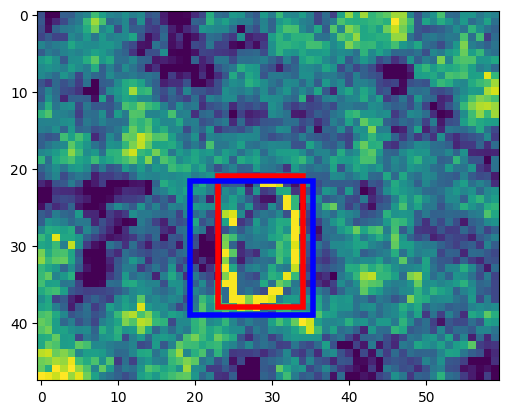

tensor(0.)
tensor(0)


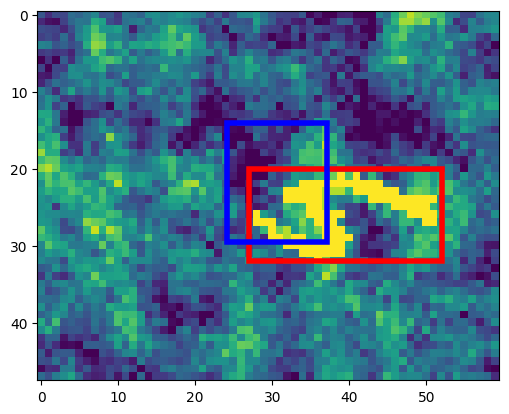

tensor(5.)
tensor(0)


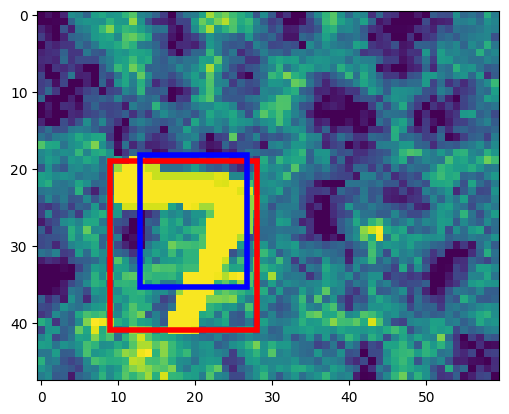

tensor(7.)
tensor(0)


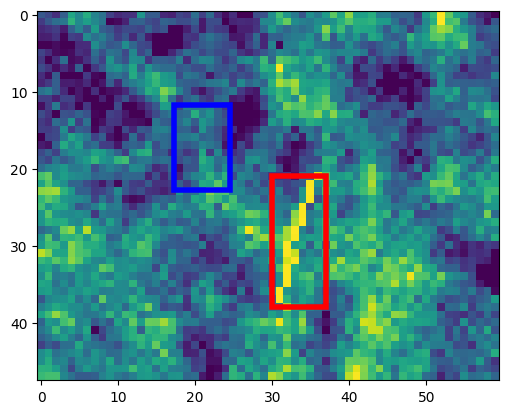

tensor(1.)
tensor(1)
Accuracy: 0.23


In [729]:
CNN_model4 = MyLeNet5(15)
optimizer = optim.SGD(CNN_model4.parameters(), lr=1e-3, weight_decay=0.1, momentum=0.5)

train(
    n_epochs = n_epochs, 
    optimizer = optimizer, 
    model = CNN_model4, 
    loss_fn = loss, 
    train_loader = train_loader)

give_img_with_boundingboxes(CNN_model4, val_loader, 5)

model4_acc = compute_accuracy(CNN_model4, val_loader)

if model4_acc > best_val_acc:
    best_model = CNN_model4
    best_model_name = 'CNN_model4'
    best_val_acc = model4_acc

# Giving the measure of the best model


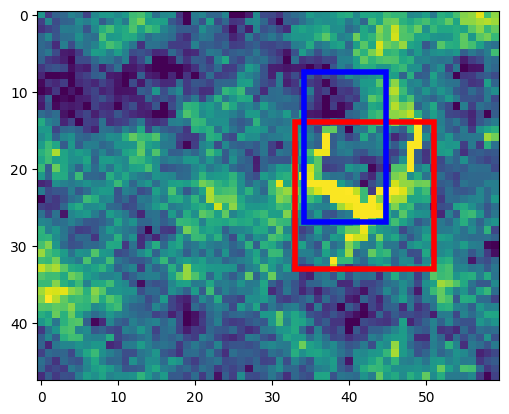

tensor(4.)
tensor(8)


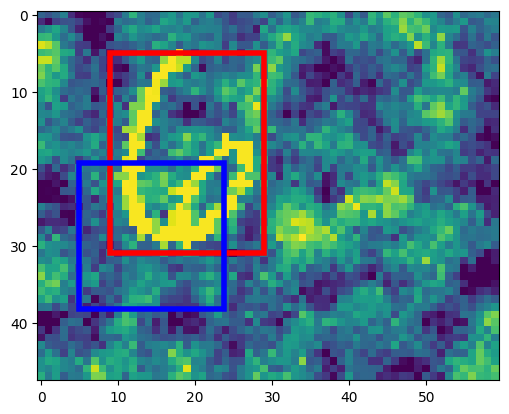

tensor(6.)
tensor(0)


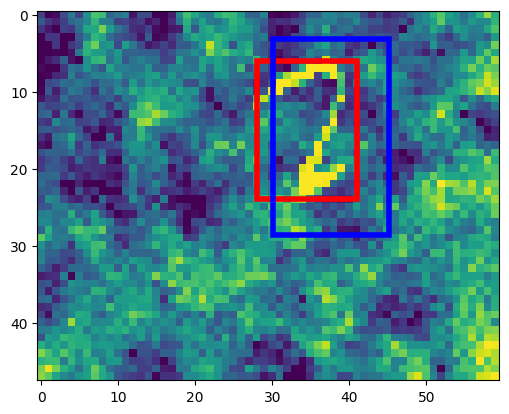

tensor(2.)
tensor(2)


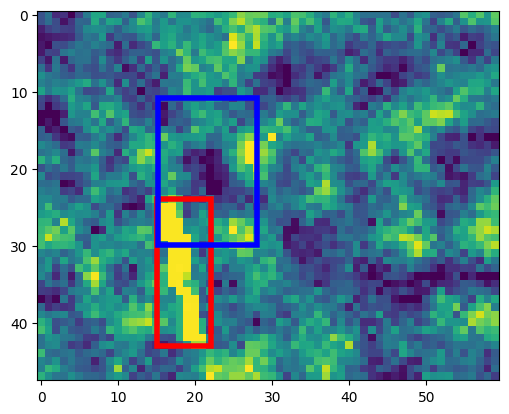

tensor(1.)
tensor(7)


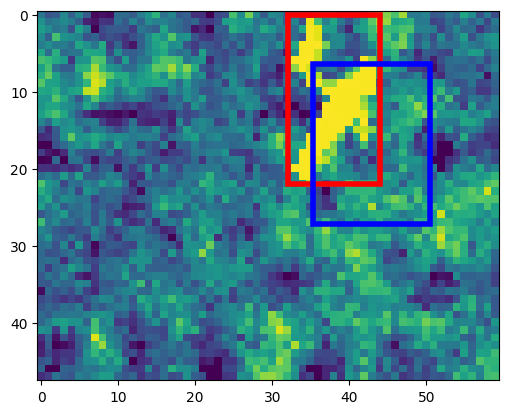

tensor(4.)
tensor(3)
Accuracy: 0.23
CNN_model1
tensor(0.2296)
tensor(0.2298)


In [756]:
test_loader = torch.utils.data.DataLoader(data_test, batch_size=512, shuffle=False)

for img, target in test_loader: 
    img = normalizer(img)

give_img_with_boundingboxes(best_model, test_loader, 5)

best_model_test_acc =  compute_accuracy(best_model, test_loader)

print(best_model_name)
print(best_val_acc)
print(best_model_test_acc)

# TASK 3.1.1


In [731]:
y_true_train = torch.load('list_y_true_train.pt')
y_true_val = torch.load('list_y_true_val.pt')
y_true_test = torch.load('list_y_true_test.pt')


In [732]:
def convert_data(data): 
    num_imgs = len(data)

    tensor_data = torch.zeros(num_imgs, 2, 3, 6)

    for i in range(num_imgs): 
        for cell in data[i]: 
            p, x, y, w, h, c = cell
            
            if y < 1/2:
                if x < 1/3:
                    tensor_data[i, 0, 0, 1] = x * 3 
                    tensor_data[i, 0, 0, 2] = y * 2

                    tensor_data[i, 0, 0, 0] = p
                    tensor_data[i, 0, 0, 3] = w * 3
                    tensor_data[i, 0, 0, 4] = h * 2
                    tensor_data[i, 0, 0, 5] = c

                
                elif x < 2/3: 
                    tensor_data[i, 0, 1, 1] = x * 3 - 1
                    tensor_data[i, 0, 1, 2] = y * 2

                    tensor_data[i, 0, 1, 0] = p
                    tensor_data[i, 0, 1, 3] = w * 3
                    tensor_data[i, 0, 1, 4] = h * 2
                    tensor_data[i, 0, 1, 5] = c
        
                else: 
                    tensor_data[i, 0, 2, 1] = x * 3 - 2
                    tensor_data[i, 0, 2, 2] = y * 2

                    tensor_data[i, 0, 2, 0] = p
                    tensor_data[i, 0, 2, 3] = w * 3
                    tensor_data[i, 0, 2, 4] = h * 2
                    tensor_data[i, 0, 2, 5] = c
            
            else: 
                if x < 1/3:
                    tensor_data[i, 1, 0, 1] = x * 3 
                    tensor_data[i, 1, 0, 2] = y * 2 - 1

                    tensor_data[i, 1, 0, 0] = p
                    tensor_data[i, 1, 0, 3] = w * 3
                    tensor_data[i, 1, 0, 4] = h * 2
                    tensor_data[i, 1, 0, 5] = c
                
                elif x < 2/3: 
                    tensor_data[i, 1, 1, 1] = x * 3 - 1
                    tensor_data[i, 1, 1, 2] = y * 2 - 1

                    tensor_data[i, 1, 1, 0] = p
                    tensor_data[i, 1, 1, 3] = w * 3
                    tensor_data[i, 1, 1, 4] = h * 2
                    tensor_data[i, 1, 1, 5] = c
        
                else: 
                    tensor_data[i, 1, 2, 1] = x * 3 - 2
                    tensor_data[i, 1, 2, 2] = y * 2 - 1

                    tensor_data[i, 1, 2, 0] = p
                    tensor_data[i, 1, 2, 3] = w * 3
                    tensor_data[i, 1, 2, 4] = h * 2
                    tensor_data[i, 1, 2, 5] = c

    return tensor_data        


def loss_sw(y_pred, y_true):

    l_a = 0
    l_b = 0
    l_c = 0

    width = 3       #Kunne blitt standarisert 
    height = 2      #Kunne blitt standarisert 

    for w in range(width):
        for h in range(height):

            i_where_num = torch.where(y_true[:, h, w, 0] == 1)
            l_a += nn.functional.binary_cross_entropy_with_logits(y_pred[:, h, w, 0], y_true[:, h, w, 0])        #”Is there an object in the image? ”.
            
            y_true_num, y_pred_num = y_true[i_where_num], y_pred[i_where_num]                       #Picking the tensors where there is a num in picture

            l_b += nn.functional.mse_loss(y_pred_num[:, h, w, 1:5], y_true_num[:, h, w, 1:5])                    #”Where is the object?”
            l_c += nn.functional.cross_entropy(y_pred_num[:, h, w, 5], y_true_num[:, h, w, 5])           #”Which class is this? ”                                                 #

    total_loss = l_a + l_b + l_c
    return total_loss


from matplotlib.patches import Rectangle
from collections import namedtuple

def give_img_with_boundingboxes_local_coordinates(model, loader,  num_imgs): 

    with torch.no_grad():
        for imgs, labels in loader: 
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)

            outputs = model(imgs)
            print(outputs.shape)

            width = outputs.shape[2]
            height = outputs.shape[1]

        for i in range(num_imgs):

            i = randint(i, len(outputs))

            fig, ax = plt.subplots()

            for w in range(width): 
                for h in range(height):

                    if labels[i, h, w, 0] != 0: 
                        tx, ty, tw, th = labels[i, h, w, 1:5]

                        #Change from local to global values: 
                        tx = (tx + w)/3
                        ty = (ty + h)/2
                        tw = tw / 3
                        th = th / 2

                        #Finding boundingboxes
                        tx = (tx - tw*0.5)*60
                        ty = (ty - th*0.5)*48
                        tw = tw * 60
                        th = th * 48

                        #Plotting the rectangle
                        plt.imshow(imgs[i].squeeze(0))
                        rect_true = Rectangle((tx,ty), tw, th,
                            edgecolor='red',
                            facecolor='none',
                            lw=4)
                        ax.add_patch(rect_true)


                        px, py, pw, ph = outputs[i, h, w, 1:5]

                        #Change from local to global values: 
                        px = (px + w)/3
                        py = (py + h)/2
                        pw = pw / 3
                        ph = ph / 2

                        px = (px - pw*0.5)*60
                        py = (py - ph*0.5)*48
                        pw = pw * 60
                        ph = ph * 48

                        plt.imshow(imgs[i].squeeze(0))
                        rect_pred = Rectangle((px,py), pw, ph,
                            edgecolor='blue',
                            facecolor='none',
                            lw=4)
                        ax.add_patch(rect_pred)

                        print(labels[i, h, w, 5].item())
                        print(0 if torch.sigmoid(outputs[i, h, w, 5]) < 0.5 else 1)

            plt.show()

                

                
Rect = namedtuple('Rectangle', 'xmin ymin xmax ymax')

def area(a, b):  
    dx = min(a.xmax, b.xmax) - max(a.xmin, b.xmin)
    dy = min(a.ymax, b.ymax) - max(a.ymin, b.ymin)
    if (dx>=0) and (dy>=0):
        return dx*dy
    else: 
        return 0 


def compute_accuracy_local_coordinates(model, loader):
    correct = 0
    total = 0
    iou = 0 
    num_ob = 0 

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)

            width = outputs.shape[2]
            height = outputs.shape[1]

            for i in range(len(labels)):
                for w in range(width):
                    for h in range(height):

                        total += 1
                        if torch.sigmoid(outputs[i, h, w, 0]) < 0.5 and labels[i, h, w, 0] == 0: 
                            correct += 1
                        

                        # if torch.sigmoid(outputs[i, h, w, 0]) >= 0.5 and labels[i, h, w, 0] == 1: 
                        if labels[i, h, w, 0] == 1:
                            num_ob += 1
                            pred = 0 if torch.sigmoid(outputs[i, h, w, 5]) < 0.5 else 1
                            true = labels[i, h, w, 5]

                            if pred == true:
                                correct += 1
                            
                            px, py, pw, ph = outputs[i, h, w, 1:5]
                            tx, ty, tw, th = labels[i, h, w, 1:5]

                            px_min, py_min, px_max, py_max = px - pw/2, py - ph/2, px + pw/2 , py + ph/2
                            tx_min, ty_min, tx_max, ty_max = tx - tw/2, ty - th/2, tx + tw/2 , ty + th/2

                            p_rect = Rect(px_min, py_min, px_max, py_max)
                            t_rect = Rect(tx_min, ty_min, tx_max, ty_max)

                            intersection = area(p_rect, t_rect)
                            union = pw*ph + tw*th - intersection
                            iou += intersection/union
                    

    acc =  ((correct / total) + (iou / num_ob)) / 2
    print("Accuracy: {:.2f}".format(acc))
    return acc

In [733]:
y_train_det = convert_data(y_true_train)
y_val_det = convert_data(y_true_val)
y_test_det = convert_data(y_true_test)

train_det = torch.load('detection_train.pt')
val_det = torch.load('detection_val.pt')
test_det = torch.load('detection_test.pt')


In [734]:
random_int = randint(0, len(y_train_det))
y_train_det[random_int]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[1.0000, 0.9000, 0.1458, 0.4000, 0.6250, 1.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]])

In [735]:
train_det[random_int][1]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[1.0000, 0.9000, 0.1458, 0.4000, 0.6250, 1.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]])

In [736]:
print(type(train_det))
ex = train_det[0]

# Type of the ith element of the training dataset: 
print("Type of the ith element in the dataset  :  ", type(ex))
print("Tuple length of this element            :  ", len(ex))
print("Type of the 1st element of the tuple    :  ", type(ex[0]))
print("Type of the 2nd element of the tuple    :  ", type(ex[1]))

# The dataset is then made like this "i_img, i_label =  cifar10_train[i]""
print(i_elt[0].size())

<class 'torch.utils.data.dataset.TensorDataset'>
Type of the ith element in the dataset  :   <class 'tuple'>
Tuple length of this element            :   2
Type of the 1st element of the tuple    :   <class 'torch.Tensor'>
Type of the 2nd element of the tuple    :   <class 'torch.Tensor'>
torch.Size([1, 48, 60])


In [737]:
class cnn_sw(nn.Module):
    def __init__(self, num_classes):
        super().__init__() 
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)  
        self.norm1 = nn.BatchNorm2d(6)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.norm2 = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv_transform = nn.Conv2d(16, 16, kernel_size=8, stride=2)

        self.fc1 = nn.Conv2d(16, 120, kernel_size=1)
        self.fc2 = nn.Conv2d(120, 84, kernel_size=1)
        self.fc3 = nn.Conv2d(84, num_classes, kernel_size=1)


    def forward(self, x):
        
        out = self.conv1(x)
        out = self.norm1(out)
        out = torch.relu(self.pool1(out))
        
        out = self.conv2(out)
        out = self.norm2(out)
        out = torch.relu(self.pool2(out))

        
        
        out = torch.relu(self.conv_transform(out))
        out = torch.relu(self.fc1(out))
        out = torch.relu(self.fc2(out))
        out = self.fc3(out)

        #change from: [n, 6, 2, 3]
        #to: [n, 2, 3, 6]

        return torch.permute(out, (0, 2, 3, 1 ))
   

In [738]:
n_epochs = 25    
train_loader = torch.utils.data.DataLoader(train_det, batch_size=512, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_det, batch_size=512, shuffle=False)

imgs = torch.stack([img for img, _ in train_det])
mean = imgs.mean()
std = imgs.std()

normalizer = transforms.Normalize(mean, std)

for img, target in train_loader:
    img = normalizer(img)

for img, target in val_loader: 
    img = normalizer(img)

best_sw_model = None
best_sw_val_acc = 0

21:28:48.188640  |  Epoch 1  |  Training loss 1578.52886
21:29:02.816330  |  Epoch 2  |  Training loss 1500.71664
21:29:16.966353  |  Epoch 3  |  Training loss 1477.49703
21:29:31.016633  |  Epoch 4  |  Training loss 1454.85294
21:29:45.340703  |  Epoch 5  |  Training loss 1446.40874
21:30:00.028547  |  Epoch 6  |  Training loss 1439.28695
21:30:14.157780  |  Epoch 7  |  Training loss 1443.31218
21:30:28.196838  |  Epoch 8  |  Training loss 1432.53812
21:30:42.590328  |  Epoch 9  |  Training loss 1430.90304
21:31:00.868670  |  Epoch 10  |  Training loss 1434.16169
21:31:17.669036  |  Epoch 11  |  Training loss 1427.43330
21:31:32.739662  |  Epoch 12  |  Training loss 1425.81806
21:31:47.181799  |  Epoch 13  |  Training loss 1425.07191
21:32:01.081125  |  Epoch 14  |  Training loss 1424.05166
21:32:14.430838  |  Epoch 15  |  Training loss 1422.88150
21:32:28.041644  |  Epoch 16  |  Training loss 1422.33727
21:32:41.551925  |  Epoch 17  |  Training loss 1432.92463
21:32:55.142185  |  Epo

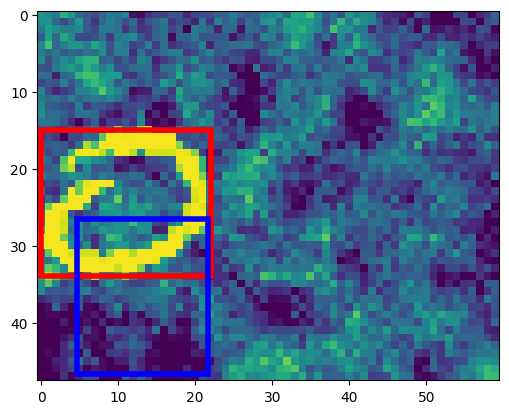

1.0
0


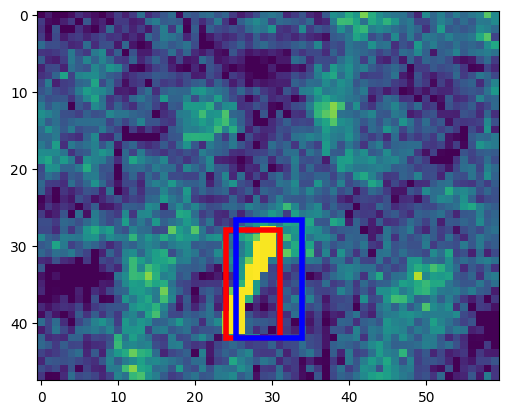

1.0
0


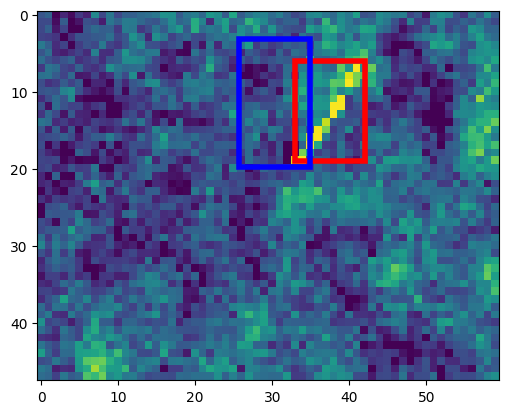

1.0
1


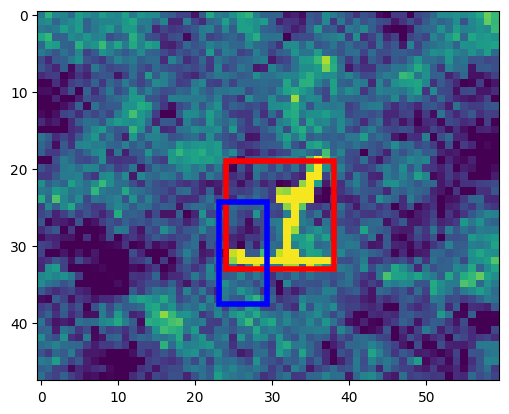

0.0
0
0.0
0


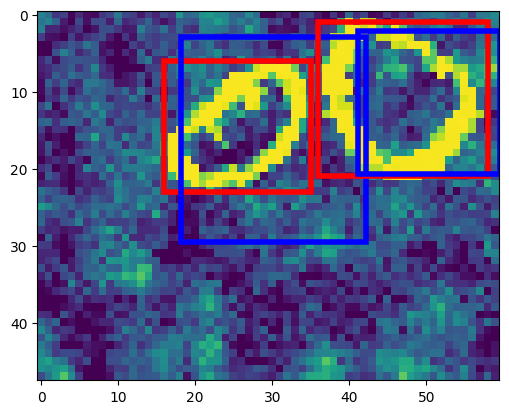

Accuracy: 0.57


In [739]:
cnn_sw_model1 = cnn_sw(6)
optimizer = optim.SGD(cnn_sw_model1.parameters(), lr=1e-3)

train(
    n_epochs = n_epochs, 
    optimizer = optimizer, 
    model = cnn_sw_model1, 
    loss_fn = loss_sw, 
    train_loader = train_loader)


give_img_with_boundingboxes_local_coordinates(cnn_sw_model1, val_loader, 5)

sw_model1_acc = compute_accuracy_local_coordinates(cnn_sw_model1, val_loader)

if sw_model1_acc > best_sw_val_acc: 
    best_sw_model = cnn_sw_model1
    best_sw_model_name = 'cnn_sw_model1'
    best_sw_val_acc = sw_model1_acc

21:35:20.071889  |  Epoch 1  |  Training loss 1572.74938
21:35:35.138178  |  Epoch 2  |  Training loss 1477.26228
21:35:49.899108  |  Epoch 3  |  Training loss 1450.14996
21:36:05.275781  |  Epoch 4  |  Training loss 1441.83712
21:36:20.248984  |  Epoch 5  |  Training loss 1441.50569
21:36:35.005742  |  Epoch 6  |  Training loss 1434.29414
21:36:50.414380  |  Epoch 7  |  Training loss 1430.95559
21:37:05.380214  |  Epoch 8  |  Training loss 1428.60936
21:37:20.363391  |  Epoch 9  |  Training loss 1426.96633
21:37:35.873833  |  Epoch 10  |  Training loss 1426.32337
21:37:51.039423  |  Epoch 11  |  Training loss 1425.70847
21:38:05.842954  |  Epoch 12  |  Training loss 1425.31938
21:38:25.351113  |  Epoch 13  |  Training loss 1426.17884
21:38:41.597179  |  Epoch 14  |  Training loss 1423.44008
21:38:58.608332  |  Epoch 15  |  Training loss 1423.54134
21:39:14.981908  |  Epoch 16  |  Training loss 1423.39385
21:39:30.760514  |  Epoch 17  |  Training loss 1423.30475
21:39:48.838237  |  Epo

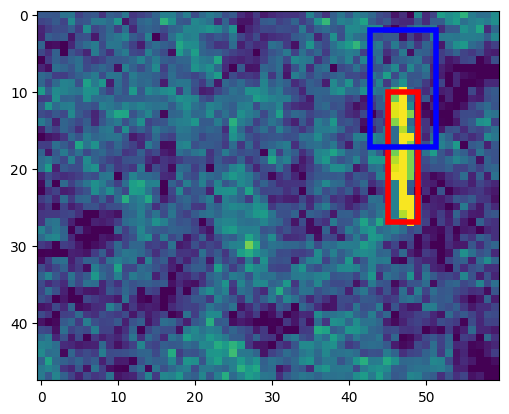

1.0
0
0.0
0


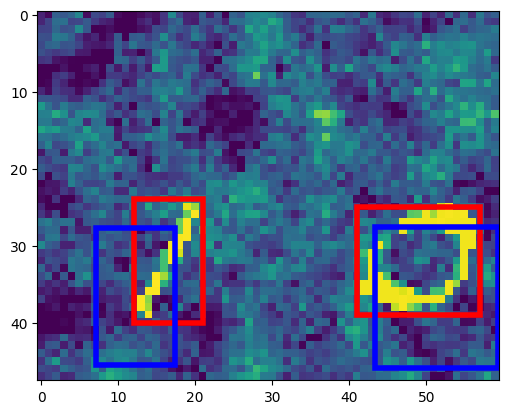

1.0
0


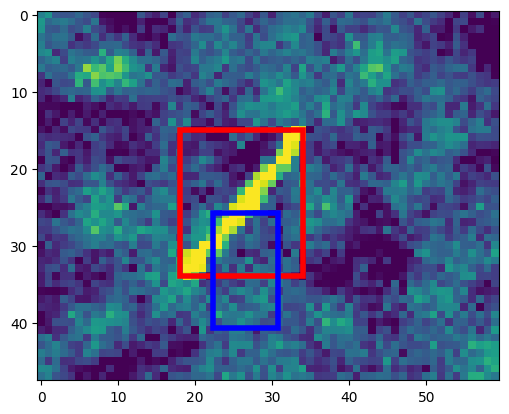

1.0
0


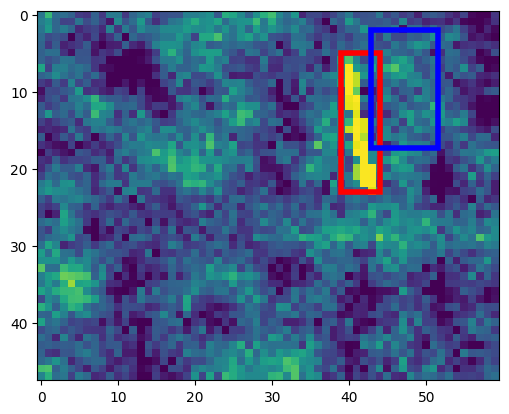

1.0
0


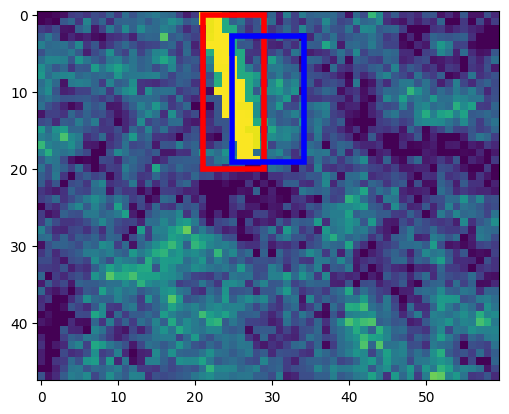

Accuracy: 0.57


In [740]:
cnn_sw_model2 = cnn_sw(6)
optimizer = optim.SGD(cnn_sw_model2.parameters(), lr=1e-3, weight_decay=0.1, momentum=0.7)

train(
    n_epochs = n_epochs, 
    optimizer = optimizer, 
    model = cnn_sw_model2, 
    loss_fn = loss_sw, 
    train_loader = train_loader)


give_img_with_boundingboxes_local_coordinates(cnn_sw_model2, val_loader, 5)

sw_model2_acc = compute_accuracy_local_coordinates(cnn_sw_model2, val_loader)

if sw_model2_acc > best_sw_val_acc: 
    best_sw_model = cnn_sw_model2
    best_sw_model_name = 'cnn_sw_model2'
    best_sw_val_acc = sw_model2_acc

21:42:04.683636  |  Epoch 1  |  Training loss 1528.63062
21:42:20.515205  |  Epoch 2  |  Training loss 1483.56682
21:42:34.892199  |  Epoch 3  |  Training loss 1467.31082
21:42:49.771351  |  Epoch 4  |  Training loss 1451.49155
21:43:04.300477  |  Epoch 5  |  Training loss 1437.60504
21:43:19.258293  |  Epoch 6  |  Training loss 1433.24349
21:43:34.540191  |  Epoch 7  |  Training loss 1433.67097
21:43:49.228494  |  Epoch 8  |  Training loss 1427.97116
21:44:04.366909  |  Epoch 9  |  Training loss 1426.96528
21:44:19.665505  |  Epoch 10  |  Training loss 1426.69063
21:44:34.700305  |  Epoch 11  |  Training loss 1437.32853
21:44:50.163676  |  Epoch 12  |  Training loss 1425.00842
21:45:05.283314  |  Epoch 13  |  Training loss 1423.89947
21:45:20.222221  |  Epoch 14  |  Training loss 1423.16077
21:45:35.643726  |  Epoch 15  |  Training loss 1430.15149
21:45:50.413849  |  Epoch 16  |  Training loss 1423.27726
21:46:07.783072  |  Epoch 17  |  Training loss 1422.15629
21:48:03.136742  |  Epo

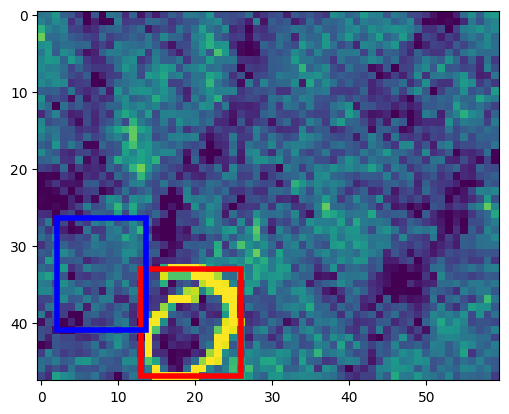

1.0
0


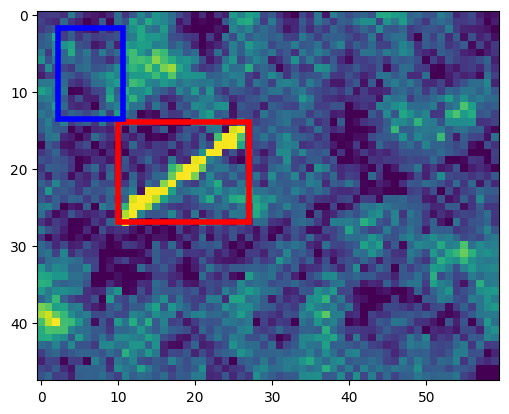

1.0
0


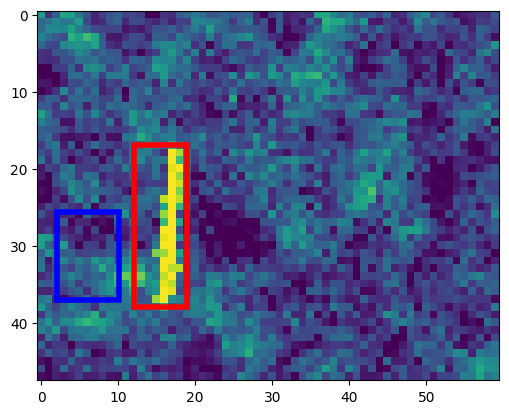

0.0
0


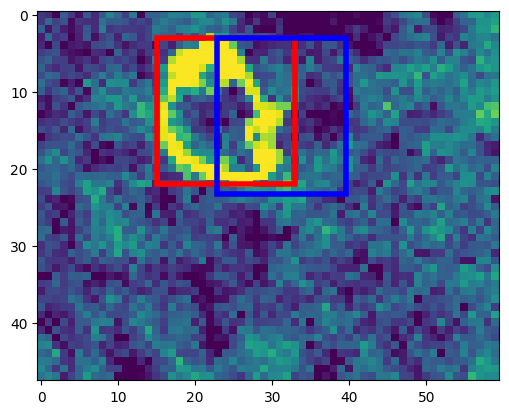

1.0
0


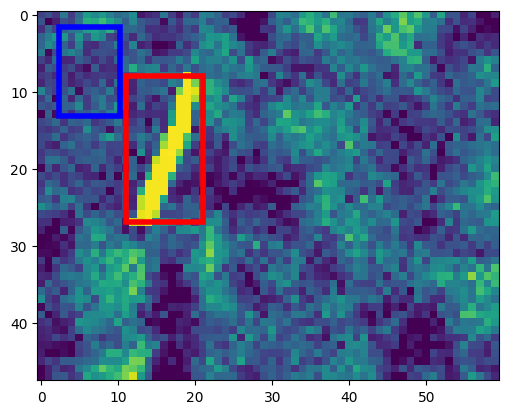

Accuracy: 0.55


In [741]:
cnn_sw_model3 = cnn_sw(6)
optimizer = optim.SGD(cnn_sw_model3.parameters(), lr=1e-3, weight_decay=0.5, momentum=0.2)

train(
    n_epochs = n_epochs, 
    optimizer = optimizer, 
    model = cnn_sw_model3, 
    loss_fn = loss_sw, 
    train_loader = train_loader)


give_img_with_boundingboxes_local_coordinates(cnn_sw_model3, val_loader, 5)

sw_model3_acc = compute_accuracy_local_coordinates(cnn_sw_model3, val_loader)

if sw_model3_acc > best_sw_val_acc: 
    best_sw_model = cnn_sw_model3
    best_sw_model_name = 'cnn_sw_model3'
    best_sw_val_acc = sw_model3_acc

21:49:57.262923  |  Epoch 1  |  Training loss 1520.19091
21:50:13.012381  |  Epoch 2  |  Training loss 1460.44308
21:50:30.862850  |  Epoch 3  |  Training loss 1444.75037
21:50:46.808992  |  Epoch 4  |  Training loss 1436.96008
21:51:01.827253  |  Epoch 5  |  Training loss 1431.85963
21:51:16.780169  |  Epoch 6  |  Training loss 1428.90214
21:51:31.271714  |  Epoch 7  |  Training loss 1427.10274
21:51:46.104995  |  Epoch 8  |  Training loss 1425.76248
21:52:00.974422  |  Epoch 9  |  Training loss 1427.23614
21:52:15.796645  |  Epoch 10  |  Training loss 1423.94540
21:52:30.336233  |  Epoch 11  |  Training loss 1423.46733
21:52:45.180775  |  Epoch 12  |  Training loss 1423.30454
21:53:00.070431  |  Epoch 13  |  Training loss 1422.66703
21:53:15.006951  |  Epoch 14  |  Training loss 1421.93977
21:53:30.066282  |  Epoch 15  |  Training loss 1423.46272
21:53:45.159364  |  Epoch 16  |  Training loss 1421.37294
21:54:00.528287  |  Epoch 17  |  Training loss 1420.96879
21:54:15.817531  |  Epo

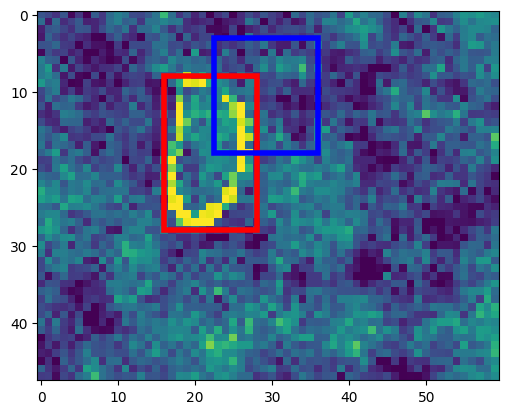

0.0
0


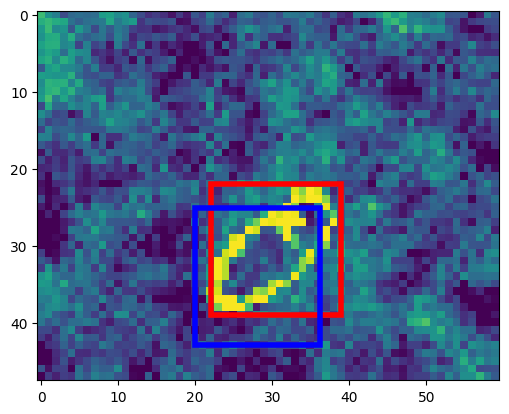

1.0
0


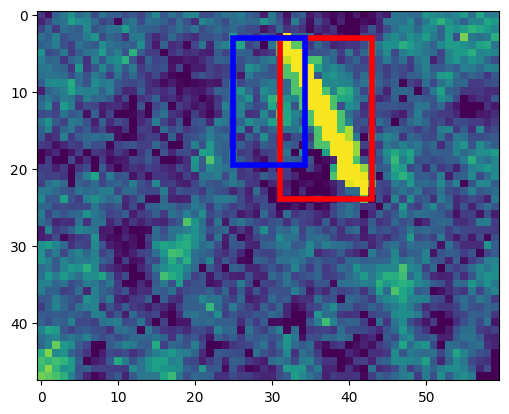

1.0
0
0.0
0


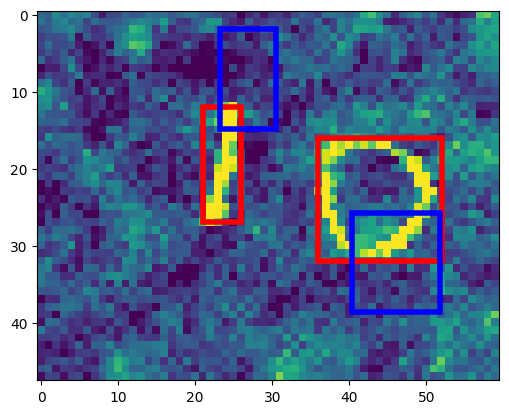

0.0
0


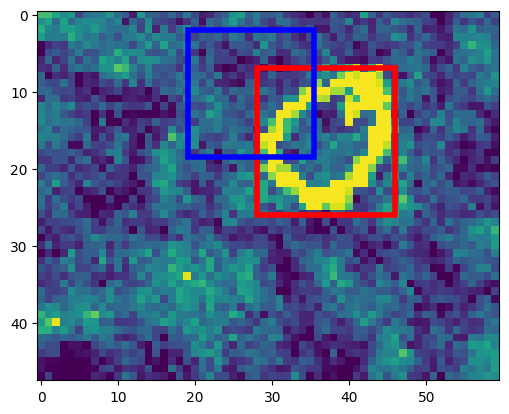

Accuracy: 0.57


In [742]:
cnn_sw_model4 = cnn_sw(6)
optimizer = optim.SGD(cnn_sw_model4.parameters(), lr=1e-3, weight_decay=0.1, momentum=0.5)

train(
    n_epochs = n_epochs, 
    optimizer = optimizer, 
    model = cnn_sw_model4, 
    loss_fn = loss_sw, 
    train_loader = train_loader)


give_img_with_boundingboxes_local_coordinates(cnn_sw_model4, val_loader, 5)

sw_model4_acc = compute_accuracy_local_coordinates(cnn_sw_model4, val_loader)

if sw_model4_acc > best_sw_val_acc: 
    best_sw_model = cnn_sw_model4
    best_sw_model_name = 'cnn_sw_model4'
    best_sw_val_acc = sw_model4_acc

torch.Size([512, 2, 3, 6])
torch.Size([512, 2, 3, 6])
torch.Size([512, 2, 3, 6])
torch.Size([512, 2, 3, 6])
torch.Size([512, 2, 3, 6])
torch.Size([512, 2, 3, 6])
torch.Size([512, 2, 3, 6])
torch.Size([512, 2, 3, 6])
torch.Size([512, 2, 3, 6])
torch.Size([373, 2, 3, 6])
0.0
0


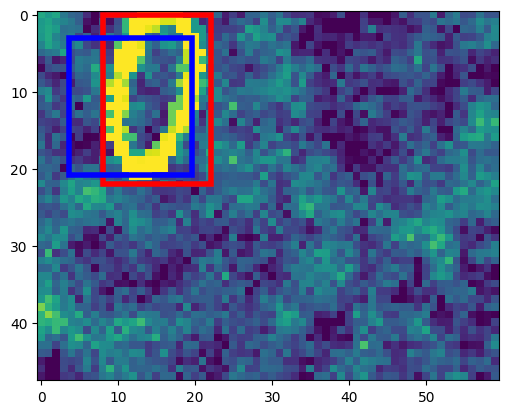

1.0
0
1.0
0


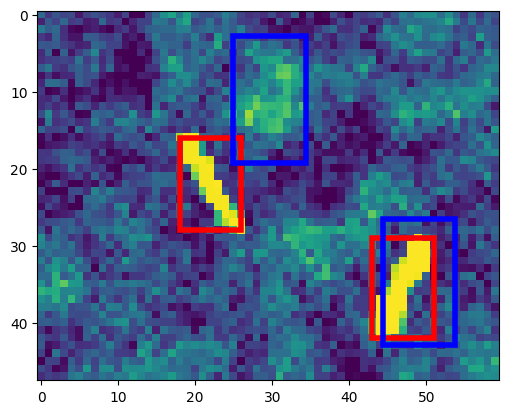

0.0
0


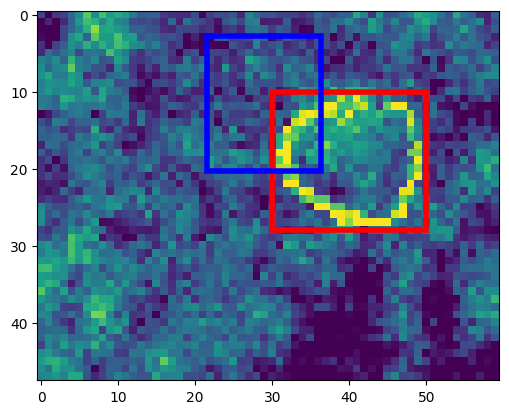

0.0
0


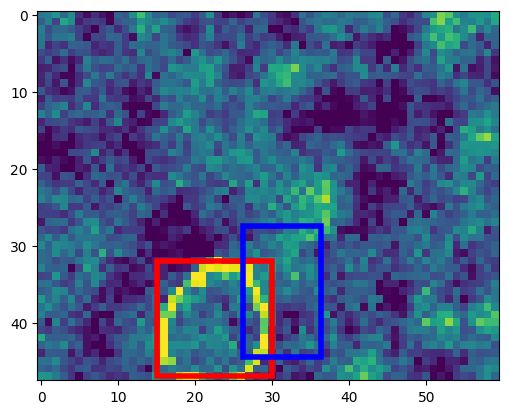

1.0
0


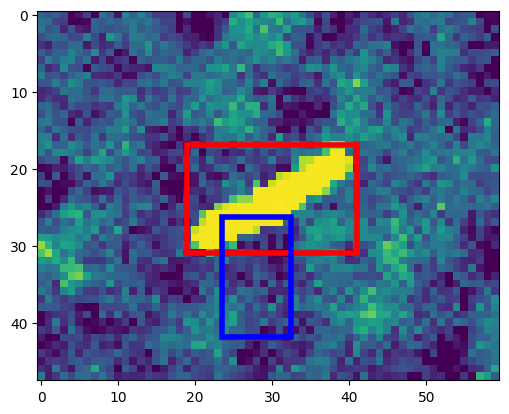

Accuracy: 0.57
cnn_sw_model2
tensor(0.5735)
tensor(0.5740)


In [754]:
test_loader_sw = torch.utils.data.DataLoader(test_det, batch_size=512, shuffle=False)

for img, target in test_loader_sw: 
    img = normalizer(img)

give_img_with_boundingboxes_local_coordinates(best_sw_model, test_loader_sw, 5)

best_sw_model_test_acc =  sw_model4_acc = compute_accuracy_local_coordinates(best_sw_model, test_loader_sw)

print(best_sw_model_name)
print(best_sw_val_acc)
print(best_sw_model_test_acc)